In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Get Configuration Details of Spark Context

In [1]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1569482442576'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '49543'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '192.168.0.7')]

## Configuration Details of Host Environment

* !conda info
* !python -m conda info
* !whoami
* !conda info --envs
* !source activate py373

 # Data Wrangling with Spark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [5]:
path = "sparkify_log_small.json"
user_log = spark.read.json(path)

In [6]:
user_log.count()

10000

In [11]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [14]:
user_log.describe('artist').show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [8]:
user_log.select(['page']).dropDuplicates().sort('page').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [25]:
user_log.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [33]:
user_log.select([ "userId", "firstname", "page", "song","ts"]).filter("userId == '1046'").orderBy(desc("ts")).collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Under The Gun', ts=1513842410284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Secrets', ts=1513842186284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song="Qu'Est-Ce Que T'Es Belle", ts=1513841947284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Tough Little Boys', ts=1513841710284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Rising Moon', ts=1513841519284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Spring', ts=1513841332284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Hero/Heroine', ts=1513841100284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='El Cuatrero', ts=1513840929284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Given Up (Album Version)', ts=1513840740284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Ask The Mountains', ts=1513840267284)

In [9]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [10]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [11]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14')

In [12]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [13]:
songs_in_hour.collect()

[Row(hour='0', count=375),
 Row(hour='1', count=249),
 Row(hour='2', count=216),
 Row(hour='3', count=228),
 Row(hour='4', count=251),
 Row(hour='5', count=339),
 Row(hour='6', count=462),
 Row(hour='7', count=479),
 Row(hour='8', count=484),
 Row(hour='9', count=430),
 Row(hour='10', count=362),
 Row(hour='11', count=295),
 Row(hour='12', count=257),
 Row(hour='13', count=248),
 Row(hour='14', count=369),
 Row(hour='15', count=375),
 Row(hour='16', count=456),
 Row(hour='17', count=454),
 Row(hour='18', count=382),
 Row(hour='19', count=302),
 Row(hour='20', count=352),
 Row(hour='21', count=276),
 Row(hour='22', count=348),
 Row(hour='23', count=358)]

In [14]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

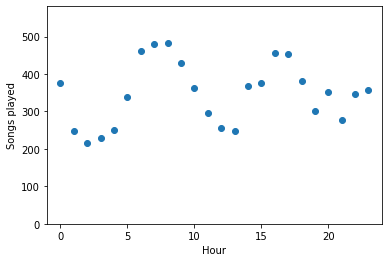

In [15]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [16]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [17]:
user_log_valid.count()

10000

In [18]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [19]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [20]:
user_log_valid.count()

9664

In [46]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   3|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [60]:
user_log_valid.select(["userId", "firstname", "page", "level",'ts',"downgraded",'phase']).where(user_log.userId == "1138").sort(desc('ts')).collect()

[Row(userId='1138', firstname='Kelly', page='NextSong', level='free', ts=1513833144284, downgraded=0, phase=0),
 Row(userId='1138', firstname='Kelly', page='Home', level='free', ts=1513821430284, downgraded=0, phase=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='free', ts=1513814880284, downgraded=0, phase=0),
 Row(userId='1138', firstname='Kelly', page='Home', level='free', ts=1513768456284, downgraded=0, phase=0),
 Row(userId='1138', firstname='Kelly', page='Submit Downgrade', level='paid', ts=1513768454284, downgraded=1, phase=1),
 Row(userId='1138', firstname='Kelly', page='Downgrade', level='paid', ts=1513768453284, downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', ts=1513768452284, downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', ts=1513768242284, downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', ts=1513768012284, downgraded=0, p

In [51]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [52]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [53]:
from pyspark.sql import Window

In [54]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [55]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [56]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

In [3]:
path = "sparkify_log_small.json"
user_log_a = spark.read.json(path)

In [22]:
#user_log_a.select('userId').dropDuplicates().sort('page').show()
user_log_a.filter(user_log_a['userid'] == '').select('page').dropDuplicates().collect()

[Row(page='Home'), Row(page='About'), Row(page='Login'), Row(page='Help')]

In [23]:
#user_log_a.select("gender").dropDuplicates().sort("userId").show()
#user_log_a.columns
user_log_a.filter(user_log_a['gender'] == 'F').select("userId").dropDuplicates().count()

462

In [43]:
#How many songs were played from the most played artist?
#user_log_a.groupby('artist').count().alias('sum').orderBy(desc('count')).collect()
user_log_a.filter(user_log_a['artist'] == 'Coldplay').select('song').count()

83

In [38]:
user_log_a.groupby('artist').count().alias('sum').orderBy(desc('count')).collect()

[Row(artist=None, count=1653),
 Row(artist='Coldplay', count=83),
 Row(artist='Kings Of Leon', count=69),
 Row(artist='Florence + The Machine', count=52),
 Row(artist='BjÃ\x83Â¶rk', count=46),
 Row(artist='Dwight Yoakam', count=45),
 Row(artist='Justin Bieber', count=43),
 Row(artist='The Black Keys', count=40),
 Row(artist='OneRepublic', count=37),
 Row(artist='Jack Johnson', count=36),
 Row(artist='Muse', count=36),
 Row(artist='Radiohead', count=31),
 Row(artist='Taylor Swift', count=29),
 Row(artist='Lily Allen', count=28),
 Row(artist='Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner', count=28),
 Row(artist='Train', count=28),
 Row(artist='Nickelback', count=27),
 Row(artist='Metallica', count=27),
 Row(artist='Daft Punk', count=27),
 Row(artist='Kanye West', count=26),
 Row(artist='John Mayer', count=24),
 Row(artist='Red Hot Chili Peppers', count=24),
 Row(artist='Alliance Ethnik', count=24),
 Row(artist='Linkin Park', count=23),
 Row(artist='Eminem', coun

In [48]:
user_log_a.sort(['sessionId','itemInSession']).select(['sessionId','itemInSession','page']).show()
udf_home = udf(lambda x : 1 if x == 'Home' else 0,IntegerType())
user_log_a = user_log_a.withColumn('home_check',)

+---------+-------------+--------+
|sessionId|itemInSession|    page|
+---------+-------------+--------+
|        9|            0|NextSong|
|       10|            0|    Home|
|       10|            1|NextSong|
|       10|            2|NextSong|
|       27|            0|    Home|
|       27|            1|NextSong|
|       27|            2|NextSong|
|       27|            3|NextSong|
|       27|            4|NextSong|
|       27|            5|NextSong|
|       27|            6|NextSong|
|       27|            7|NextSong|
|       27|            8|NextSong|
|       27|            9|NextSong|
|       27|           10|NextSong|
|       27|           11|    Home|
|       27|           12|NextSong|
|       27|           13|NextSong|
|       27|           14|NextSong|
|       27|           15|NextSong|
+---------+-------------+--------+
only showing top 20 rows



In [39]:
from pyspark.sql.functions import desc
path = "sparkify_log_small.json"
user_log_a = spark.read.json(path)
user_log_a = user_log_a.orderBy(user_log_a.userId , user_log_a.ts.cast("float").desc())
user_log_a.select('artist').dropDuplicates().collect()
user_log_a.select(['artist','userid']).dropDuplicates().orderBy('artist').collect()
user_log_a.select(['userid']).dropDuplicates().orderBy('userid').count()

964

In [43]:
from pyspark.sql.functions import col
user_log_a.filter(user_log_a['page'] == 'Home').where(col('userid')!= "").orderBy('artist').show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|   Elijah|     M|            0|    Moore|  null| free|New Orleans-Metai...|   GET|Home|1488073913284|     6316|null|   200|1513839673284|"Mozilla/5.0 (Win...|   100|
|  null|Logged In|   Elijah|     M|            3|    Moore|  null| free|New Orleans-Metai...|   GET|Home|1488073913284|     6040|null|   200|1513776194284|"Mozilla/5.0 (Win...|   100|
|  null|Logged In|   Elijah|     M|            0|    Moore|  null| free|New Orle

In [44]:
user_log_a = user_log_a.where(col('userid')!= "")

In [47]:
user_log_a = user_log_a.orderBy(col('userid'),col('ts').desc())

In [106]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import datetime 
path = "sparkify_log_small.json"
user_log_a = spark.read.json(path)
udf_hour = udf(lambda x : datetime.datetime.fromtimestamp(x/1000).hour, IntegerType())
user_log_a = user_log_a.withColumn('hour',udf_hour('ts'))
user_log_a.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       Showaddywaddy|Logged In|  Kenneth|     M|          112| Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|  14|
|          Lily Allen|Logged In|Elizabeth|     F|            7|    Chase|195.23873| free|Shrevep

In [68]:
user_log_a.where(col('page') == 'Home').groupBy('userid').count().orderBy('count').where(col('count') > 2 ).show()

+------+-----+
|userid|count|
+------+-----+
|   429|    3|
|  1165|    3|
|  2168|    3|
|  1398|    3|
|  2412|    3|
|   761|    3|
|   308|    3|
|   926|    3|
|   649|    3|
|  1854|    3|
|  1911|    3|
|  2164|    3|
|   856|    3|
|   644|    3|
|  1079|    3|
|  2426|    3|
|   512|    3|
|   100|    3|
|  2759|    3|
|  1887|    3|
+------+-----+
only showing top 20 rows



In [71]:
user_log_a.where(col('userid') == '429').show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|        Donald Fagen|Logged In|    Cesar|     M|            0| Johnson|381.09995| paid|San Antonio-New B...|   PUT| NextSong|1513431505284|     6789|New Frontier (Alb...|   200|1513848289284|"Mozilla/5.0 (Win...|   429|   1|
|                null|Logged In|    Cesar|     M|            0| Johnson|     null| paid|San Anto

In [13]:
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

In [112]:
udf_home = udf(lambda x : 1 if x == 'Home' else 0,IntegerType())

In [113]:
user_log_a = user_log_a.withColumn("home_page",udf_home(col('page')))
user_log_a.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour',
 'home_page']

In [114]:
user_log_a.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour',
 'home_page']

In [116]:
user_log_a = user_log_a.select('userId', 'firstName', 'sessionId', 'itemInSession', 'lastName',  'level',   'method', 'page', 'song',  'ts', 'hour', 'home_page')

In [117]:
window_range = Window.partitionBy('userid').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding,0)
window_rows = Window.partitionBy('userid').orderBy(desc('ts')).rowsBetween(Window.unboundedPreceding,0)

In [118]:
user_log_a = user_log_a.withColumn('window_range',sum('home_page').over(window_range)).withColumn('window_rows',sum('home_page').over(window_rows))

In [122]:
user_log_a.filter(col('userid') ==  '2294').show()

+------+---------+---------+-------------+--------+-----+------+--------+--------------------+-------------+----+---------+------------+-----------+
|userId|firstName|sessionId|itemInSession|lastName|level|method|    page|                song|           ts|hour|home_page|window_range|window_rows|
+------+---------+---------+-------------+--------+-----+------+--------+--------------------+-------------+----+---------+------------+-----------+
|  2294|   Tyanna|     2293|           65|   Jones| paid|   PUT|  Logout|                null|1513787468284|   8|        0|           0|          0|
|  2294|   Tyanna|     2293|           64|   Jones| paid|   PUT|NextSong| California Dreaming|1513787467284|   8|        0|           0|          0|
|  2294|   Tyanna|     2293|           63|   Jones| paid|   PUT|NextSong|    ThÃÂ¨me De Yoyo|1513786920284|   8|        0|           0|          0|
|  2294|   Tyanna|     2293|           62|   Jones| paid|   PUT|NextSong|Shine On (Album V...|151378673728

In [1]:
path = "sparkify_log_small.json"
cusum = spark.read.json(path)

In [8]:
from pyspark.sql.functions import col

df.select(['userid','ts','sessionid','itemInSession','page']).filter(col('userid') != '').orderBy('userid',col('ts').desc()).show()

+------+-------------+---------+-------------+--------+
|userid|           ts|sessionid|itemInSession|    page|
+------+-------------+---------+-------------+--------+
|    10|1513828388284|     6676|            0|NextSong|
|    10|1513790894284|        9|            0|NextSong|
|   100|1513839673284|     6316|            0|    Home|
|   100|1513776308284|     6040|            4|NextSong|
|   100|1513776194284|     6040|            3|    Home|
|   100|1513775710284|     6040|            2|NextSong|
|   100|1513775556284|     6040|            1|NextSong|
|   100|1513775431284|     6040|            0|    Home|
|   100|1513750442284|     5762|            1|NextSong|
|   100|1513750214284|     5762|            0|NextSong|
|  1000|1513720878284|     5027|            7|NextSong|
|  1003|1513749525284|     1002|            2|    Home|
|  1003|1513749516284|     1002|            1|NextSong|
|  1003|1513749501284|     1002|            0|    Home|
|  1005|1513782278284|     4250|            0|Ne

In [34]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc 
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())
path = "sparkify_log_small.json"
cusum = spark.read.json(path)
user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))).orderBy('userid','ts') \
    .withColumn('period', Fsum('homevisit').over(user_window)).filter(col('userid') != '') 

#cusum.filter((cusum.page == 'NextSong')) \
#    .groupBy('userID', 'period') \
#    .agg({'period':'count'}) \
#    .agg({'count(period)':'avg'}).show()

In [40]:
#cusum.filter(col('period') > 2).orderBy(desc('userid')).show()
cusum.filter(col('userid') == '761').collect()

[Row(userID='761', page='NextSong', ts=1513785588284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513785411284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513785181284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513784910284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513784687284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513784491284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513784262284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513784027284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513783827284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513783598284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513783325284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513783154284, homevisit=0, period=0),
 Row(userID='761', page='NextSong', ts=1513782904284, homevisit=

In [50]:
cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}).filter(col('userid') == '761')\
    .agg({'count(period)':'avg'}).show()
#.collect() 
##\.agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
|              51.0|
+------------------+



In [49]:
cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}).filter(col('userid') == '761').show()

51

12.75